# **Preprocessing and Baseline- Edition 1**

## **Introduction**

This notebook demonstrates a time series analysis on financial data. I'm going to use **ARIMA** and **linear regression models** to predict the change in **Net Income Loss** over time.

## **Data Preparation**

- Load the dataset.
- Selecting right variables and preprocess the data.

## **Model Building and Evaluation**

- Build an **ARIMA** model.
- Build a **linear regression** model.
- Evaluate both models using appropriate metrics (e.g., **MSE**, **RMSE**, **MAE**).

Load the dataset:

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Load the dataset from the specified path
# Load the dataset from the specified path
# Load the dataset using a relative path
file_path = r'abbot_sample.csv'
df = pd.read_csv(file_path)

## Selecting the Right Variables and Preprocessing the Data

The dataset contains information about various tickers and their performance across different dates, quarters, and other time spans.

As a result, I chose to group the data by tickers.

### Handling the Timespan

Each ticker has data reported on a yearly and quarterly basis. Therefore, it's important to ensure that the model appropriately handles this time structure. Each combination of `fy` (fiscal year) and `fp_bs` (fiscal period) will be treated as a unique time point.

### Selecting the Right Variables

#### Core Financial Features:
- **Revenues**: Indicates the total income generated.
- **GrossProfit**: Useful for understanding the company's profitability before accounting for operating expenses.
- **ProfitLoss**: Represents the net profit or loss for the period, which could be strongly related to `NetIncomeLoss`.

#### Target Variable:
- **NetIncomeLoss**: Remains a strong candidate for the target variable, representing the net outcome after all expenses.

### Potential Additional Features:
Below is a list of additional features that may be considered, but were not included in the baseline model:
- **Revenues**: Should be included as it directly impacts profitability.
- **GrossProfit**: Include it to see how profitability before operating expenses impacts the net outcome.
- **ProfitLoss**: While it might be highly correlated with `NetIncomeLoss`, including it could provide additional context or could be dismissed if it shows multicollinearity with the target.

In [37]:
# Ensure the date is a combination of fiscal year and period for unique time representation
df['date'] = df['fy'].astype(str) + '-' + df['fp_bs']

# Sorting the dataframe by ticker and date
df = df.sort_values(by=['cik', 'date'])

# Feature Selection
features = ['Revenues', 'GrossProfit', 'ProfitLoss']
target = 'NetIncomeLoss'

# Prepare data for modeling
df = df[['cik', 'date'] + features + [target]]
df = df.set_index(['cik', 'date'])

# Iterate through each ticker (cik) and apply the model
results = {}
for ticker in df.index.get_level_values('cik').unique():
    ticker_data = df.loc[ticker]

    # Baseline Model: ARIMA
    # Choose an ARIMA(p,d,q) model; p,d,q can be tuned further
    arima_model = ARIMA(ticker_data[target], order=(1, 1, 1))
    arima_result = arima_model.fit()

    # Baseline predictions
    arima_pred = arima_result.predict(start=1, end=len(ticker_data))

    # Simple Model: Linear Regression
    X = ticker_data[features]
    y = ticker_data[target]

    # Time series split for validation
    tscv = TimeSeriesSplit(n_splits=5)
    mse_scores = []
    mae_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        lin_reg_model = LinearRegression()
        lin_reg_model.fit(X_train, y_train)
        y_pred = lin_reg_model.predict(X_test)

        mse_scores.append(mean_squared_error(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))

    # Store results for the ticker
    results[ticker] = {
        "ARIMA_LogLikelihood": arima_result.llf,
        "LinearRegression_MSE": np.mean(mse_scores),
        "LinearRegression_MAE": np.mean(mae_scores),
        "ARIMA_Predictions": arima_pred,
        "LinearRegression_Predictions": lin_reg_model.predict(X)
    }

/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dda/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmod

Results for Ticker 1800:
ARIMA Log-Likelihood: -1340.4754005565312
Linear Regression MSE: 887825131922004.8
Linear Regression MAE: 12524112.461210538


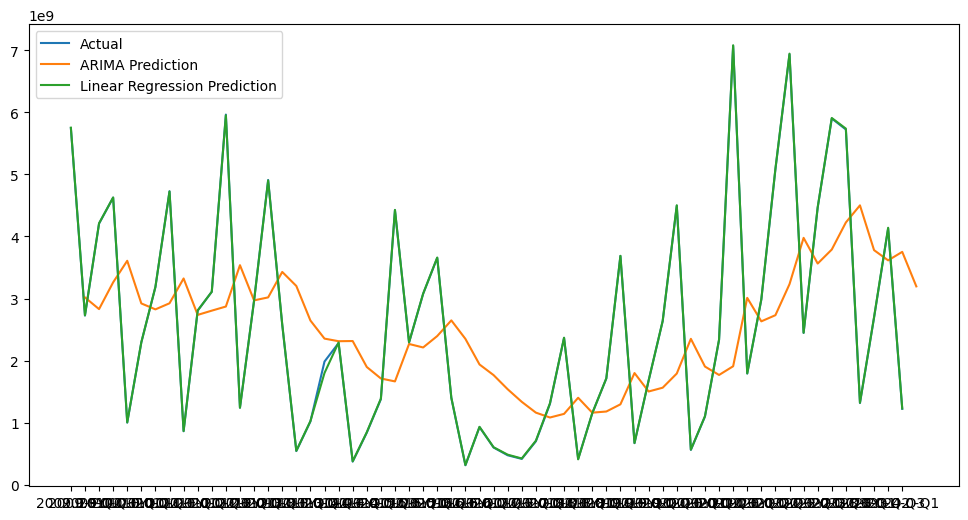

In [38]:
# Accessing results for a specific ticker
sample_ticker = list(results.keys())[0]
print(f"Results for Ticker {sample_ticker}:")
print(f"ARIMA Log-Likelihood: {results[sample_ticker]['ARIMA_LogLikelihood']}")
print(f"Linear Regression MSE: {results[sample_ticker]['LinearRegression_MSE']}")
print(f"Linear Regression MAE: {results[sample_ticker]['LinearRegression_MAE']}")

# Visualization (Optional)
plt.figure(figsize=(12, 6))
plt.plot(df.loc[sample_ticker][target], label='Actual')
plt.plot(results[sample_ticker]['ARIMA_Predictions'], label='ARIMA Prediction')
plt.plot(results[sample_ticker]['LinearRegression_Predictions'], label='Linear Regression Prediction')
plt.legend()
plt.show()